In [47]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [48]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [49]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from datetime import timedelta


In [50]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [51]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

C:\Users\jdimi\AppData\Local\Temp\ipykernel_6844\3601434573.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [52]:
# Print all of the classes mapped to the Base
for table_name in Base.classes.keys():
    print(table_name)

station
measurement


In [53]:
# Assign the measurement class to a variable called `Measurement` and
# the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [54]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [55]:
# Find the most recent date in the data set.
recent_date = session.query(func.max(Measurement.date)).first()[0]
print(recent_date)

2017-08-23


<function matplotlib.pyplot.show(close=None, block=None)>

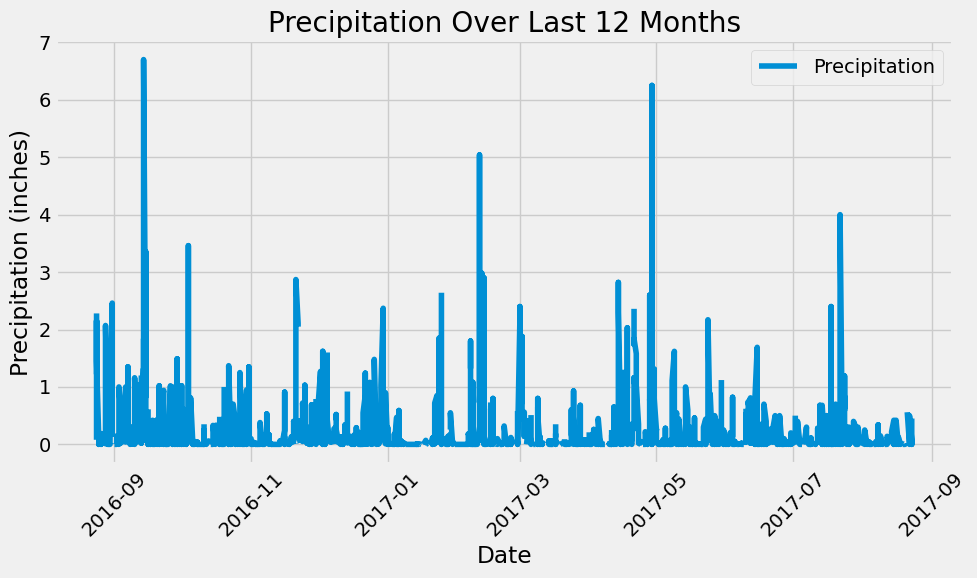

In [56]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date = datetime.strptime(most_recent_date, "%Y-%m-%d")
# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_date - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp)\
    .filter(Measurement.date >= one_year_ago)\
    .order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['Date', 'Precipitation'])
df['Date'] = pd.to_datetime(df['Date'])
# Sort the dataframe by date
df = df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10,6))
plt.plot(df['Date'], df['Precipitation'], label='Precipitation')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation Over Last 12 Months')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show

In [57]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = df['Precipitation'].describe()
print(summary_statistics)

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [58]:
# Design a query to calculate the total number of stations in the dataset
total_station_query = session.query(func.count(Station.station)).all()
print(f"Total number of stations: {total_station_query[0][0]}")

Total number of stations: 9


In [59]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations_query = (
    session.query(Measurement.station, func.count(Measurement.station))
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.station).desc())
    .all()
)

for station, count in most_active_stations_query:
    print(f"Station: {station}, Count: {count}")

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [61]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = most_active_stations_query[0][0]

# Query lowest, highest, and average tempuratures
temperature_stats_query = (
    session.query(
        func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs)
    )
    .filter(Measurement.station == most_active_station_id)
    .all()
)
# Extract results
lowest_temp, highest_temp, avg_temp = temperature_stats_query[0]

# Display the temperature statistics
print(f"Most Active Station ID: {most_active_station_id}")
print(f"Lowest Temperature: {lowest_temp}°F")
print(f"Highest Temperature: {highest_temp}°F")
print(f"Average Temperature: {avg_temp:.2f}°F")

Most Active Station ID: USC00519281
Lowest Temperature: 54.0°F
Highest Temperature: 85.0°F
Average Temperature: 71.66°F


In [62]:
# Debug: Check the values of most_active_station_id and one_year_ago
print(f"Most Active Station ID: {most_active_station_id}")
print(f"One Year Ago Date: {one_year_ago}")

Most Active Station ID: USC00519281
One Year Ago Date: 2016-08-23 00:00:00


In [63]:
# Convert one_year_ago to string format if necessary
one_year_ago_str = one_year_ago.strftime('%Y-%m-%d')
# Debug: Verify one_year_ago as string
print(f"One Year Ago Date (String): {one_year_ago_str}")

One Year Ago Date (String): 2016-08-23


In [64]:
# Perform the query for temperature data
temperature_data_query = (
    session.query(Measurement.date, Measurement.tobs)
    .filter(Measurement.station == most_active_station_id)
    .filter(Measurement.date >= one_year_ago_str)
    .all()
)

# Debug: Check if the query returned any data
if len(temperature_data_query) == 0:
    print("No temperature data found for the given station and date range.")
else:
    print(f"Number of records retrieved: {len(temperature_data_query)}")

Number of records retrieved: 352


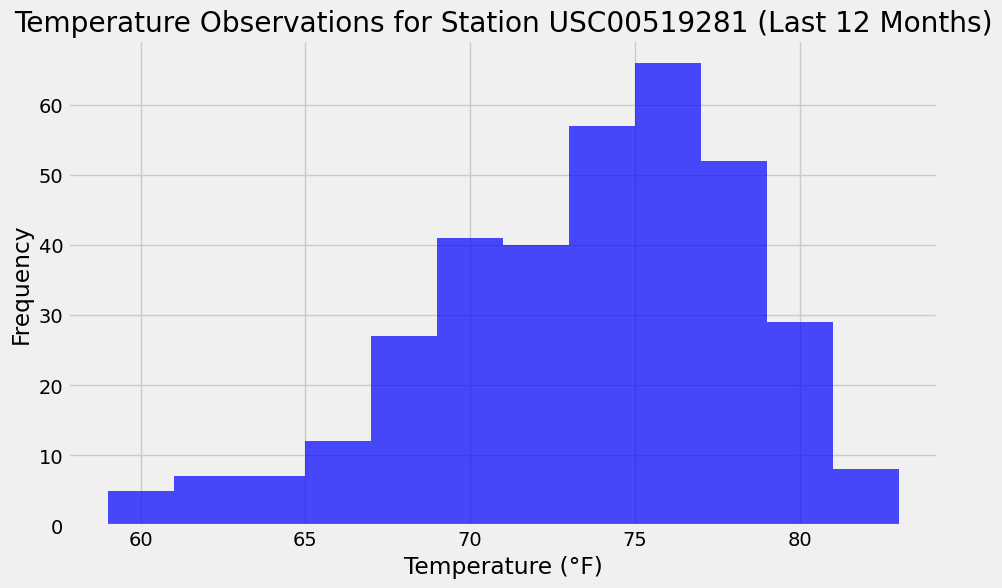

In [65]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data_query = (
    session.query(Measurement.date, Measurement.tobs)
    .filter(Measurement.station == most_active_station_id)
    .filter(Measurement.date >= one_year_ago)
    .all()
)

# Convert query to df
temperature_df = pd.DataFrame(temperature_data_query, columns=['date', 'tobs'])

# Plot the histogram if data exists
if not temperature_df.empty:
    plt.figure(figsize=(10, 6))
    
    # Create the histogram
    plt.hist(temperature_df['tobs'], bins=12, alpha=0.7, color='b')
    
    # Add labels and title
    plt.title(f'Temperature Observations for Station {most_active_station_id} (Last 12 Months)')
    plt.xlabel('Temperature (°F)')
    plt.ylabel('Frequency')
    
    # Show the plot
    plt.show()
else:
    print("No data available for plotting.")

# Close Session

In [66]:
# Close Session
session.close()
